The purpose of this code is to quantify the nuclei, the size and number of synuclein inclusions, and the lysosomal surface area in the lysotracker experiments.

Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk
import czifile
import skimage.io as io
from cellpose import models
model = models.Cellpose(model_type='cyto')

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, 

Define Sub Functions

In [2]:
def show_image(image):
    io.imshow(image)
    plt.show()
    
def calculate_surface_area(labeled_image, channel=None):
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image, channel)
    return sum(prop.area for prop in props)

def preprocess_dapi_channel(dapi_channel):
    """Preprocess the DAPI channel for nuclei quantification."""
    blurred_dapi = gaussian(dapi_channel, sigma=2)
    threshold_value = threshold_otsu(blurred_dapi)
    binary_image = blurred_dapi > threshold_value
    # show_image(binary_image)
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image

def count_nuclei(labeled_image):
    """Count the number of nuclei in the labeled image."""
    return len(np.unique(labeled_image)) - 1

def calculate_metrics(basename, cell_size,num_inclusions,total_inclusion_areas,htra_areas,overlap_areas,num_nuclei):
    """Calculate additional metrics and return the second DataFrame."""

    return pd.DataFrame({
        "File_Name:": [basename],
        "Number_of_Inclusions": [np.sum(num_inclusions)],
        "Number_of_Nuclei": [num_nuclei],
        "Cell_Area": [np.sum(cell_size)],
        "Inclusion_Area": [np.sum(total_inclusion_areas)],
        "HTRA_Area": [np.sum(htra_areas)],
        "Overlap_Area": [np.sum(overlap_areas)],
        "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],
        "Overlap_to_HTRA_Area": [np.sum(overlap_areas) / np.sum(htra_areas)],
    })



In [3]:
def analyze_image(image_path, basename):
    """
    Analyze an image by its individual cells
    Args:
        image_path: Path to the .czi image file.
        basename: Base name for the file, used in the output DataFrame.

    Returns:
        A DataFrame containing details about each image 
        A second DataFrame containing details about each detected cell
    """
    
    # Load the image and squeeze dimensions
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)

    # Separate the channels
    red_channel = image_squeezed[0, :, :]
    green_channel = image_squeezed[1, :, :]
    dapi_channel = image_squeezed[2, :, :]

    # Process DAPI channel for nuclei counting
    labeled_image_dapi = preprocess_dapi_channel(dapi_channel)
    num_nuclei = count_nuclei(labeled_image_dapi)

    # Apply Gaussian filter and thresholding on the red channel
    threshold_red = threshold_otsu(gaussian(red_channel))
    red_channel_thresholded = gaussian(red_channel) > threshold_red

    # Detect cells in the green channel
    masks, flows, styles, diams = model.eval(green_channel, diameter=100, channels=[0, 0])
    # masks, flows, styles, diams = model.eval(image_squeezed, diameter=280, channels=[2, 3])
    show_image(masks)
    labeled_cells = label(masks)

    # Initialize lists to store results
    cell_counter = []
    cell_size = []
    num_inclusions = []
    total_inclusion_areas = []
    htra_areas = []
    overlap_areas = []
    average_inclusion_areas = []

    inclusion_areas_list = []
    inclusion_counter = []

    # Analyze each detected cell
    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 300:  # Filter out small cells
            continue
        
        
        cell_counter.append(i)
        cell_size.append(cell.area)
        


        mask = labeled_cells == cell.label

        htra = red_channel_thresholded & mask
        
        if 'noHTRA' in basename:
            htra_areas.append(0)
        else:
            htra_area = calculate_surface_area(label(htra))
            htra_areas.append(htra_area)

        applied_mask = gaussian(green_channel) * mask
        thresholds = threshold_multiotsu(applied_mask,classes=3)
        
        # threshold = threshold_otsu(applied_mask)
        
        inclusions = applied_mask > (thresholds[1])
        inclusions_labeled = label(inclusions)
        cell_area = cell.area
        
        
        

        inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled) if inclusion.area > 10]
        inclusion_areas = np.array(inclusion_areas)
        total_inclusion_area = np.sum(inclusion_areas)
        average_inclusion_area = np.mean(inclusion_areas)
        
        
        if (total_inclusion_area == 0 or 
            total_inclusion_area/cell_area > 0.3 or 
            np.any(inclusion_areas>max(cell_area*0.3,2000)) or
            average_inclusion_area/cell_area > 0.1): 
            # cells that seem to have abnormally large inclusions after thresholding actually have no inclusions.
            num_inclusions.append(0)
            overlap_areas.append(0)
            total_inclusion_areas.append(0)
            average_inclusion_areas.append(0)
            continue

        
        print('Cell: ', i)
        print('Inclusion Area', total_inclusion_area)
        print('Max Inclusion Area:',np.max(inclusion_areas))
        print('Cell Area:', cell_area)
        print('Ratio:', total_inclusion_area/cell_area)
        print('Max Inclusion/Cell Area:', np.max(inclusion_areas)/cell_area)
        print('Average Inclusion/Cell Area', average_inclusion_area/cell_area)
        
        show_image(inclusions)

        total_inclusion_areas.append(total_inclusion_area)
        
        if 'noHTRA' in basename:
            overlap_areas.append(0)
        else:
            overlap = htra & inclusions
            overlap_area = calculate_surface_area(label(overlap))
            overlap_areas.append(overlap_area)       

        num_inclusions.append(len(inclusion_areas))

        inclusion_areas_list.append(inclusion_areas)
        inclusion_counter.append(range(len(inclusion_areas)))

        average_inclusion_areas.append(average_inclusion_area)
    
    df1 = calculate_metrics(basename, cell_size,num_inclusions,total_inclusion_areas,htra_areas,overlap_areas,num_nuclei)
    
    df2 = pd.DataFrame({
        "File_Name": [basename] * len(cell_counter),
        "Cell": cell_counter,
        "Cell_Area": cell_size,
        "Num_Inclusions": num_inclusions,
        "Inclusion_Area": total_inclusion_areas,
        "Average_Inclusion_Area": average_inclusion_areas,
        "HTRA_Area": htra_areas,
        "Overlap_Area": overlap_areas,
        "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),
        "Overlap_to_HTRA_Area": np.array(overlap_areas)/np.array(htra_areas)
    })
    if len(inclusion_counter) == 0:
        df3 = pd.DataFrame()
    else:
        df3 = pd.DataFrame({
            "File_Name": [basename] * len(np.concatenate(inclusion_counter)),
            "Inclusion": np.concatenate(inclusion_counter),
            "Inclusion_Area": np.concatenate(inclusion_areas_list)
        })

    
    return df1, df2, df3


In [4]:
def analyze_all_images(image_folder):
    all_data_1 = []
    all_data_2 = []
    all_data_3 = []
    for well_image in os.listdir(image_folder):
        print(well_image)
        
        if well_image.lower().endswith(".czi"):  # Filter for CZI files
            well_image_path = os.path.join(image_folder, well_image)
            well_image_base_name = os.path.basename(well_image)[:-4]
            
            df1, df2, df3 = analyze_image(well_image_path, well_image_base_name)
            all_data_1.append(df1)
            all_data_2.append(df2)
            all_data_3.append(df3)

    combined_df_1 = pd.concat(all_data_1, ignore_index=True)
    combined_df_1.to_excel(f"{image_folder[:6]}_analysis_by_image.xlsx", index=False)

    combined_df_2 = pd.concat(all_data_2, ignore_index=True)
    combined_df_2.to_excel(f"{image_folder[:6]}_analysis_by_cell.xlsx", index=False)

    combined_df_3 = pd.concat(all_data_3, ignore_index=True)
    combined_df_3.to_excel(f"{image_folder[:6]}_analysis_by_inclusion.xlsx", index=False)

Define Main Function

1K_PFF_HTRA1_Hoechst_20x_01.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


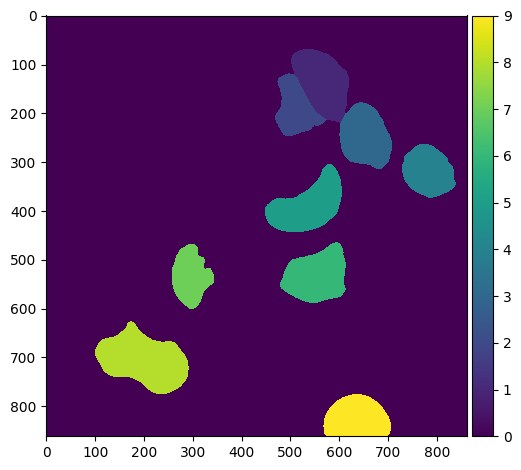

Cell:  6
Inclusion Area 307.0
Max Inclusion Area: 307.0
Cell Area: 7623.0
Ratio: 0.04027285845467664
Max Inclusion/Cell Area: 0.04027285845467664
Average Inclusion/Cell Area 0.04027285845467664


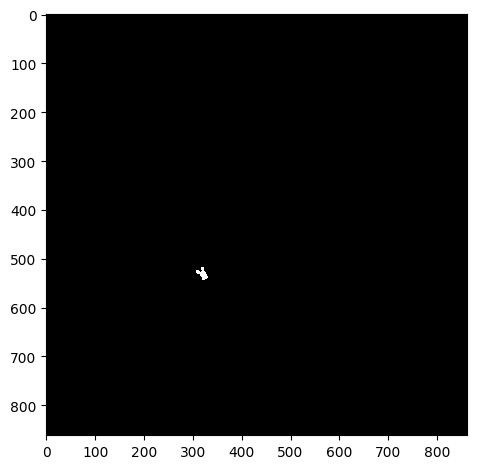

Cell:  7
Inclusion Area 4541.0
Max Inclusion Area: 1409.0
Cell Area: 17261.0
Ratio: 0.26307861653438386
Max Inclusion/Cell Area: 0.08162910607728405
Average Inclusion/Cell Area 0.01461547869635466


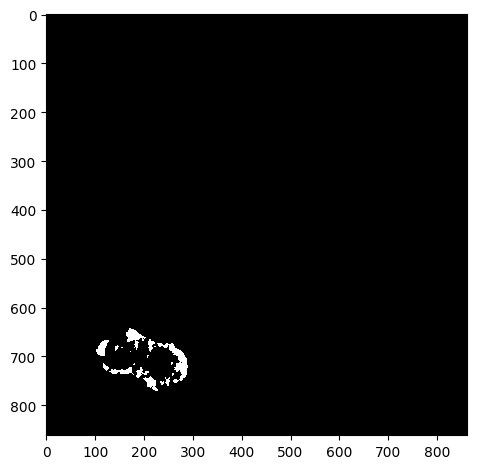

1K_PFF_HTRA1_Hoechst_20x_02.czi


C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2309923543.py:136: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),
C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2309923543.py:137: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_HTRA_Area": np.array(overlap_areas)/np.array(htra_areas)


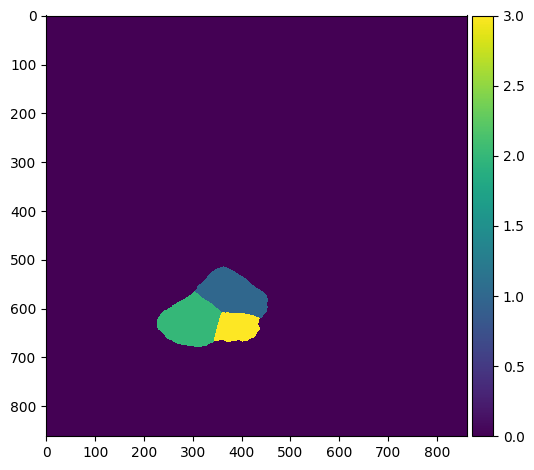

Cell:  0
Inclusion Area 578.0
Max Inclusion Area: 460.0
Cell Area: 9551.0
Ratio: 0.060517223327400275
Max Inclusion/Cell Area: 0.04816249607370956
Average Inclusion/Cell Area 0.010086203887900045


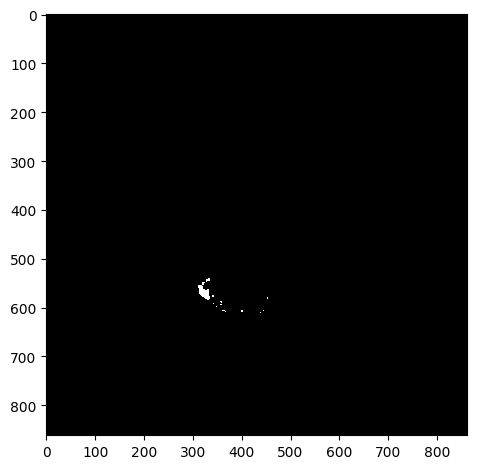

Cell:  1
Inclusion Area 1957.0
Max Inclusion Area: 562.0
Cell Area: 10159.0
Ratio: 0.19263707057781276
Max Inclusion/Cell Area: 0.055320405551727535
Average Inclusion/Cell Area 0.012842471371854186


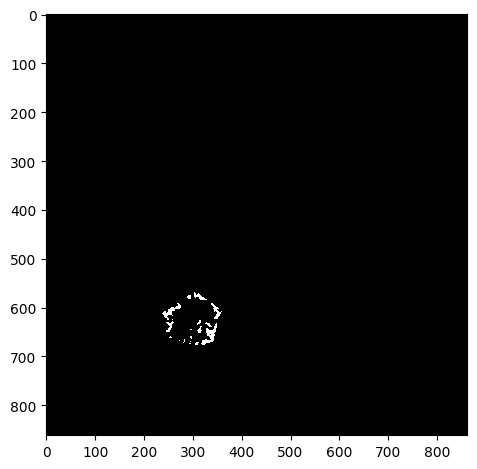

Cell:  2
Inclusion Area 1205.0
Max Inclusion Area: 881.0
Cell Area: 4583.0
Ratio: 0.2629282129609426
Max Inclusion/Cell Area: 0.1922321623390792
Average Inclusion/Cell Area 0.02921424588454918


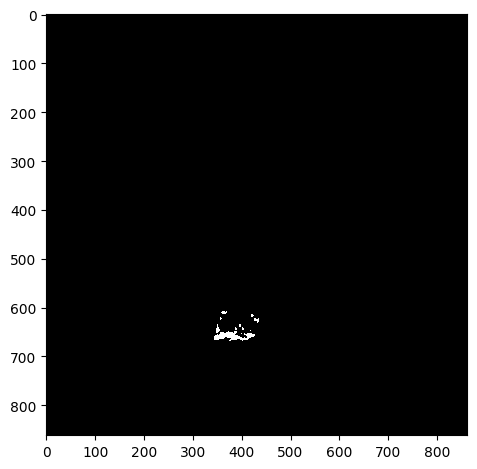

1K_PFF_HTRA1_Hoechst_20x_03.czi


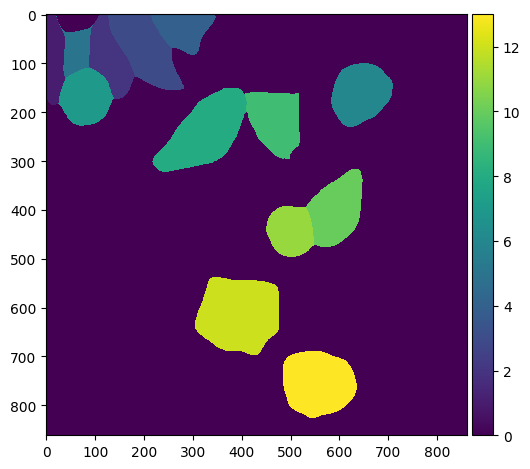

Cell:  2
Inclusion Area 2922.0
Max Inclusion Area: 1700.0
Cell Area: 13903.0
Ratio: 0.21017046680572538
Max Inclusion/Cell Area: 0.12227576781989499
Average Inclusion/Cell Area 0.010508523340286268


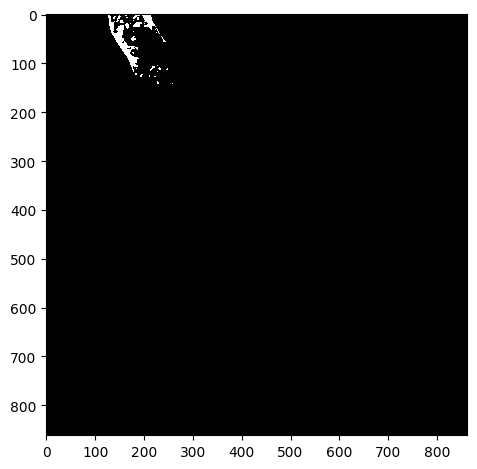

Cell:  16
Inclusion Area 1214.0
Max Inclusion Area: 285.0
Cell Area: 11841.0
Ratio: 0.10252512456718182
Max Inclusion/Cell Area: 0.024068913098555866
Average Inclusion/Cell Area 0.005695840253732323


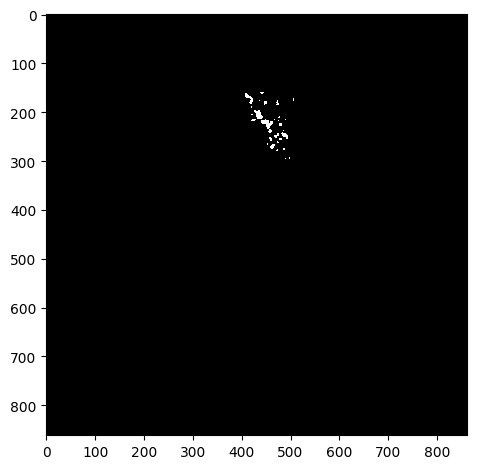

Cell:  19
Inclusion Area 377.0
Max Inclusion Area: 357.0
Cell Area: 21851.0
Ratio: 0.017253214955837263
Max Inclusion/Cell Area: 0.016337925037755708
Average Inclusion/Cell Area 0.008626607477918631


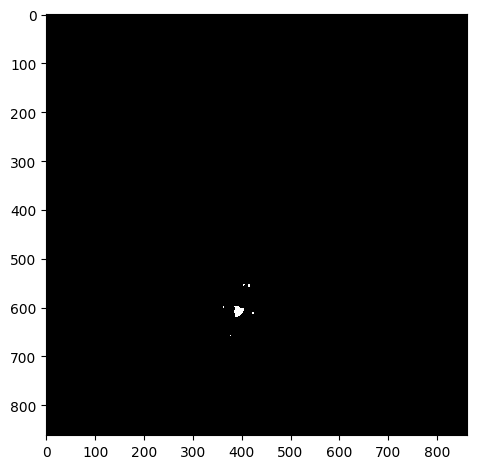

Cell:  20
Inclusion Area 646.0
Max Inclusion Area: 570.0
Cell Area: 16452.0
Ratio: 0.03926574276683686
Max Inclusion/Cell Area: 0.03464624361779723
Average Inclusion/Cell Area 0.009816435691709214


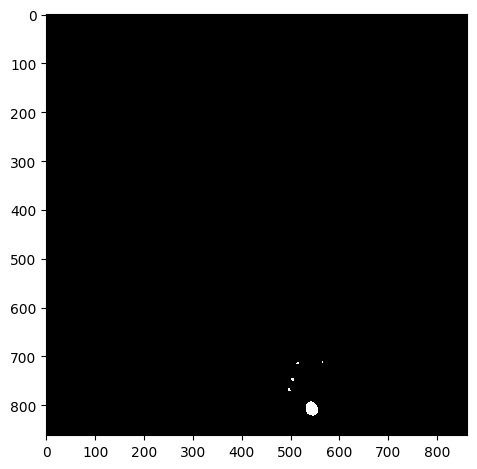

1K_PFF_HTRA1_Hoechst_20x_04.czi


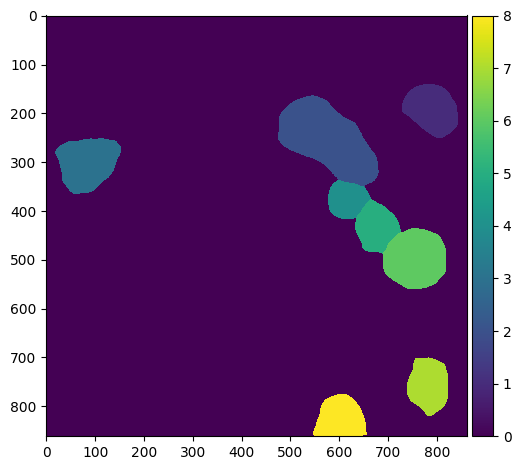

C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],


1K_PFF_HTRA1_Hoechst_20x_05.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


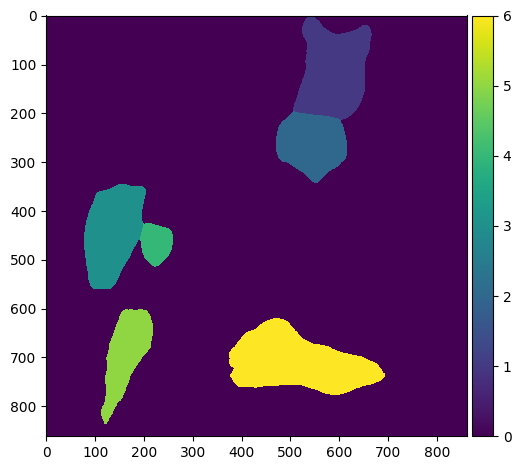

Cell:  4
Inclusion Area 523.0
Max Inclusion Area: 381.0
Cell Area: 12932.0
Ratio: 0.040442313640581505
Max Inclusion/Cell Area: 0.029461800185586143
Average Inclusion/Cell Area 0.010110578410145376


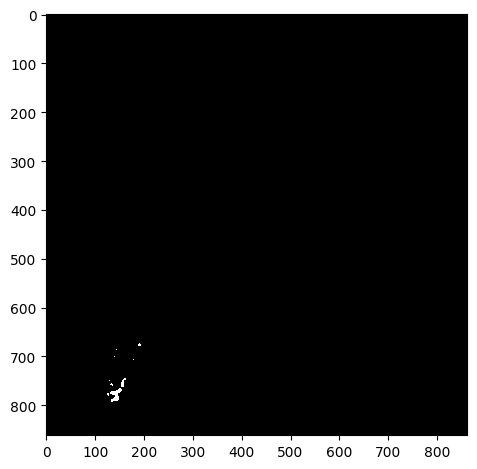

Cell:  5
Inclusion Area 3663.0
Max Inclusion Area: 497.0
Cell Area: 29881.0
Ratio: 0.12258625882667916
Max Inclusion/Cell Area: 0.01663264281650547
Average Inclusion/Cell Area 0.0020096108004373633


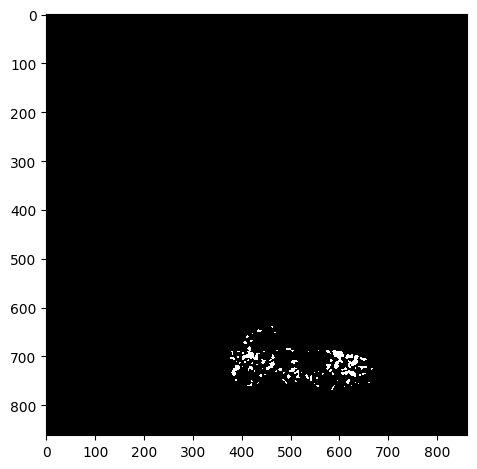

1K_PFF_HTRA1_Hoechst_20x_06.czi


C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2309923543.py:136: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),


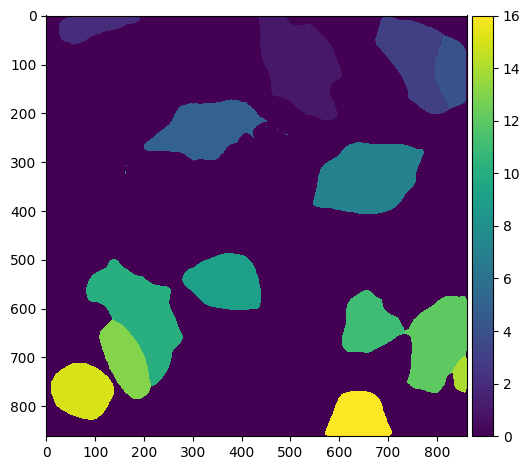

Cell:  4
Inclusion Area 3756.0
Max Inclusion Area: 1100.0
Cell Area: 18703.0
Ratio: 0.20082339731593862
Max Inclusion/Cell Area: 0.05881409399561568
Average Inclusion/Cell Area 0.004183820777415388


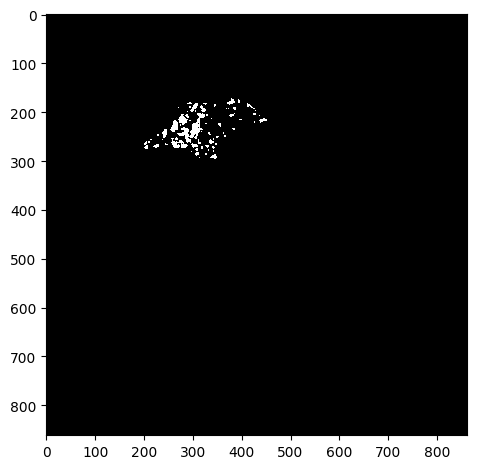

Cell:  30
Inclusion Area 942.0
Max Inclusion Area: 881.0
Cell Area: 10340.0
Ratio: 0.09110251450676983
Max Inclusion/Cell Area: 0.08520309477756287
Average Inclusion/Cell Area 0.018220502901353967


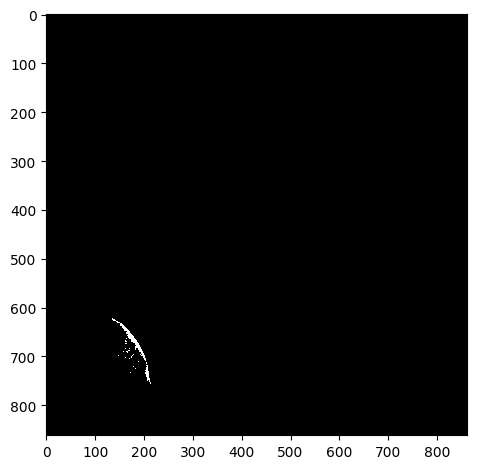

1K_PFF_HTRA1_Hoechst_20x_07.czi


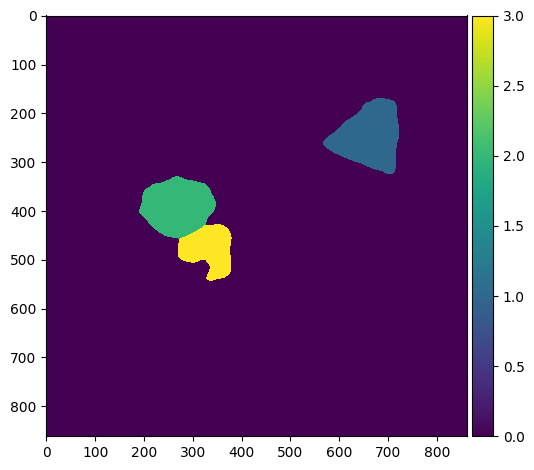

Cell:  1
Inclusion Area 628.0
Max Inclusion Area: 355.0
Cell Area: 14461.0
Ratio: 0.0434271488832031
Max Inclusion/Cell Area: 0.02454878639098264
Average Inclusion/Cell Area 0.00868542977664062


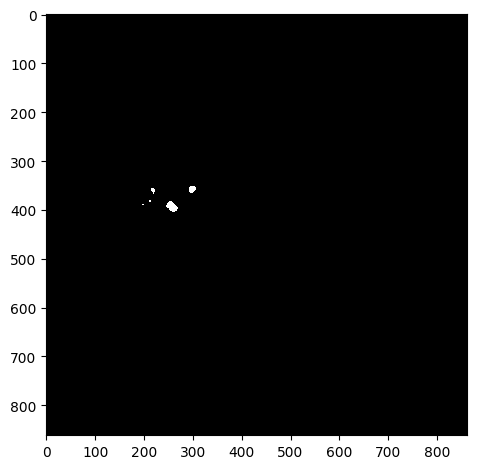

Cell:  2
Inclusion Area 149.0
Max Inclusion Area: 99.0
Cell Area: 8599.0
Ratio: 0.017327596232120015
Max Inclusion/Cell Area: 0.011512966624026049
Average Inclusion/Cell Area 0.004331899058030004


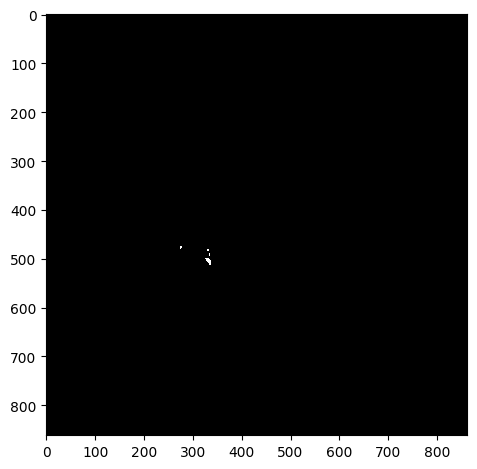

1K_PFF_HTRA1_Hoechst_20x_08.czi


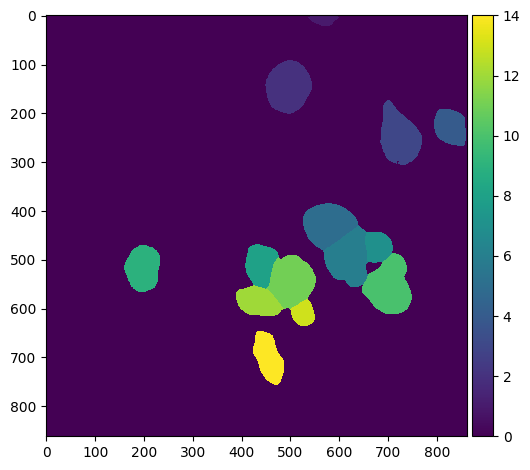

Cell:  4
Inclusion Area 1871.0
Max Inclusion Area: 1508.0
Cell Area: 7338.0
Ratio: 0.2549741073862088
Max Inclusion/Cell Area: 0.20550558735350233
Average Inclusion/Cell Area 0.03642487248374411


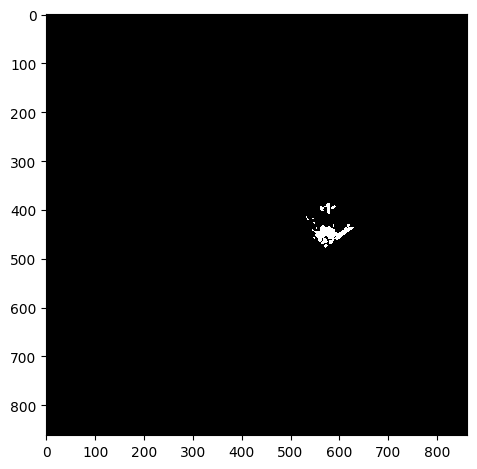

Cell:  5
Inclusion Area 1493.0
Max Inclusion Area: 769.0
Cell Area: 7820.0
Ratio: 0.19092071611253197
Max Inclusion/Cell Area: 0.09833759590792839
Average Inclusion/Cell Area 0.047730179028132994


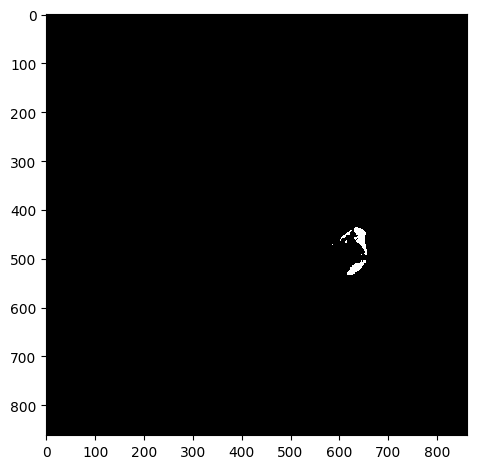

Cell:  7
Inclusion Area 86.0
Max Inclusion Area: 86.0
Cell Area: 4354.0
Ratio: 0.01975195222783647
Max Inclusion/Cell Area: 0.01975195222783647
Average Inclusion/Cell Area 0.01975195222783647


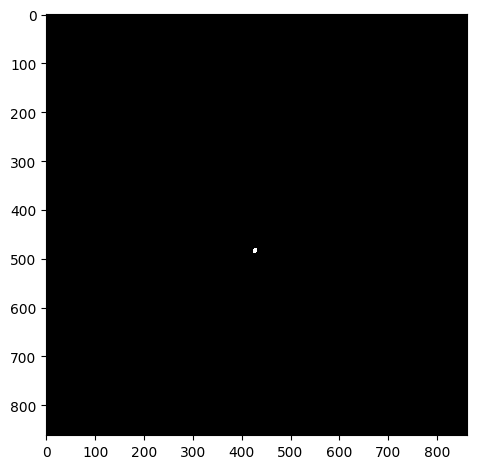

Cell:  10
Inclusion Area 431.0
Max Inclusion Area: 308.0
Cell Area: 7790.0
Ratio: 0.05532734274711168
Max Inclusion/Cell Area: 0.03953786906290115
Average Inclusion/Cell Area 0.02766367137355584


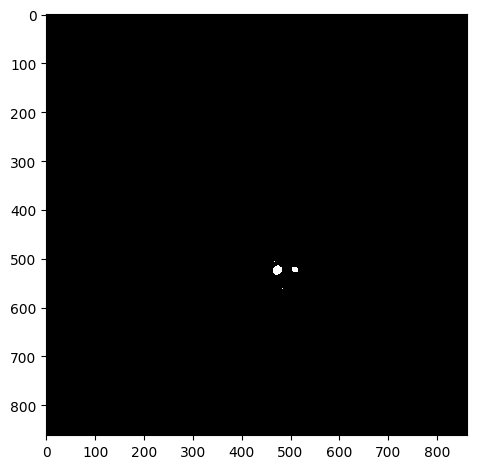

Cell:  13
Inclusion Area 143.0
Max Inclusion Area: 143.0
Cell Area: 4657.0
Ratio: 0.0307064633884475
Max Inclusion/Cell Area: 0.0307064633884475
Average Inclusion/Cell Area 0.0307064633884475


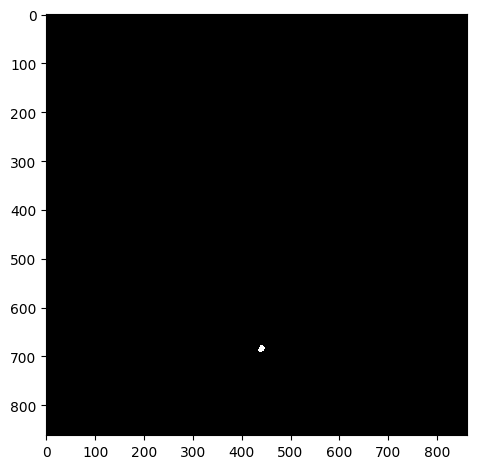

1K_PFF_HTRA1_Hoechst_20x_09.czi


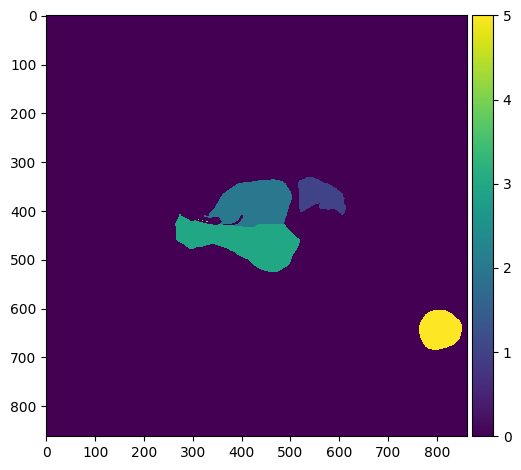

Cell:  1
Inclusion Area 350.0
Max Inclusion Area: 331.0
Cell Area: 12311.0
Ratio: 0.028429859475266023
Max Inclusion/Cell Area: 0.026886524246608725
Average Inclusion/Cell Area 0.014214929737633011


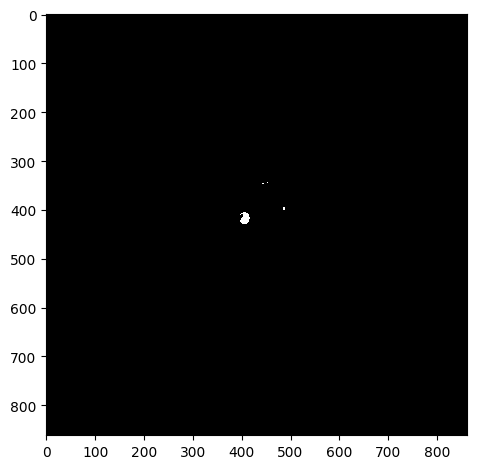

Cell:  2
Inclusion Area 1229.0
Max Inclusion Area: 401.0
Cell Area: 16084.0
Ratio: 0.0764113404625715
Max Inclusion/Cell Area: 0.024931609052474508
Average Inclusion/Cell Area 0.005877795420197807


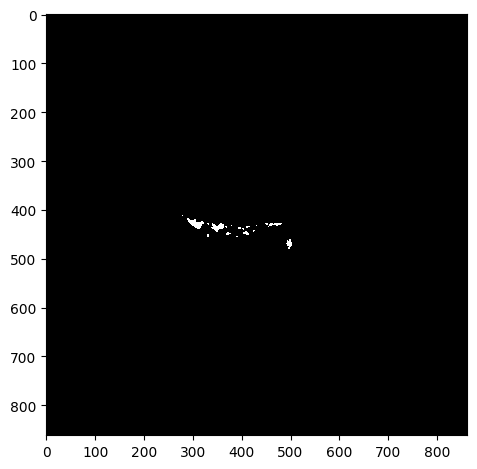

1K_PFF_HTRA1_Hoechst_20x_10.czi


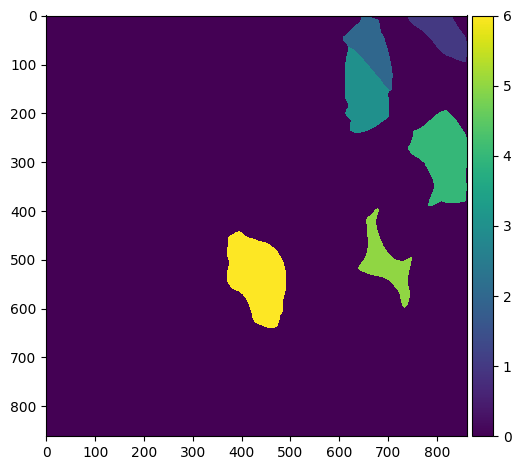

Cell:  5
Inclusion Area 1126.0
Max Inclusion Area: 349.0
Cell Area: 16774.0
Ratio: 0.06712769762728031
Max Inclusion/Cell Area: 0.020806009300107307
Average Inclusion/Cell Area 0.0055939748022733595


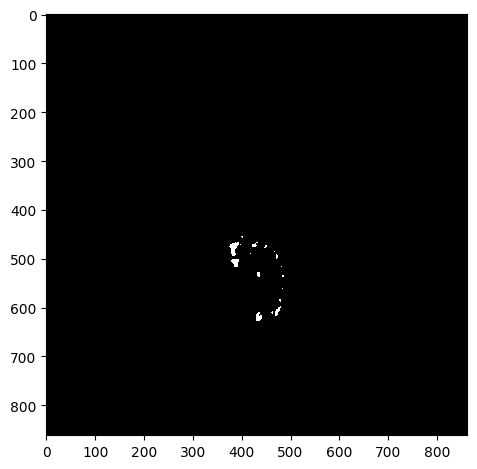

C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2309923543.py:137: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_HTRA_Area": np.array(overlap_areas)/np.array(htra_areas)


1K_PFF_no_HTRA1_Hoechst_20x_01.czi


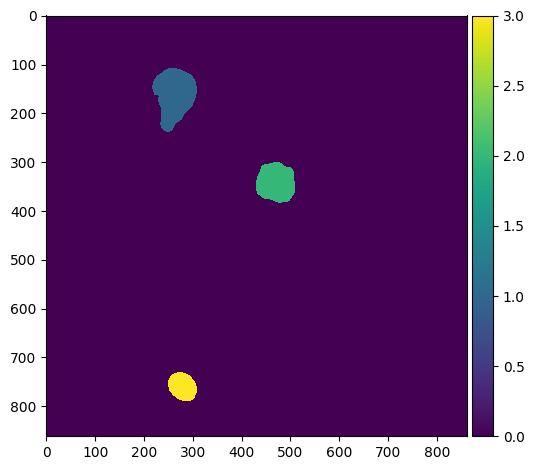

Cell:  1
Inclusion Area 133.0
Max Inclusion Area: 133.0
Cell Area: 5285.0
Ratio: 0.025165562913907286
Max Inclusion/Cell Area: 0.025165562913907286
Average Inclusion/Cell Area 0.025165562913907286


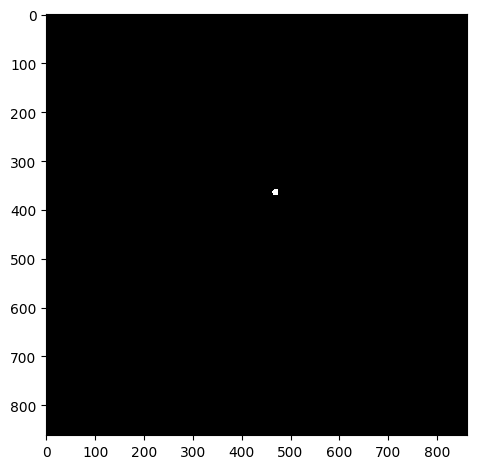

Cell:  2
Inclusion Area 711.0
Max Inclusion Area: 651.0
Cell Area: 2725.0
Ratio: 0.26091743119266053
Max Inclusion/Cell Area: 0.23889908256880735
Average Inclusion/Cell Area 0.08697247706422018


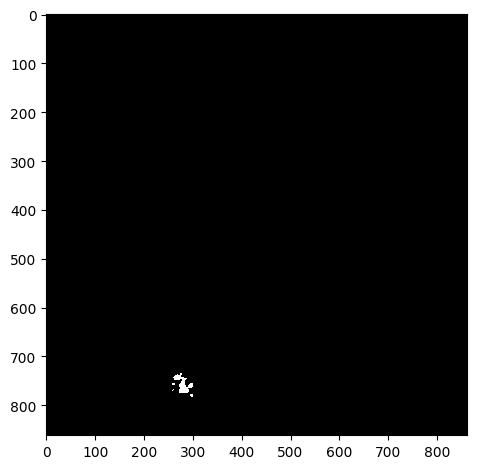

1K_PFF_no_HTRA1_Hoechst_20x_02.czi


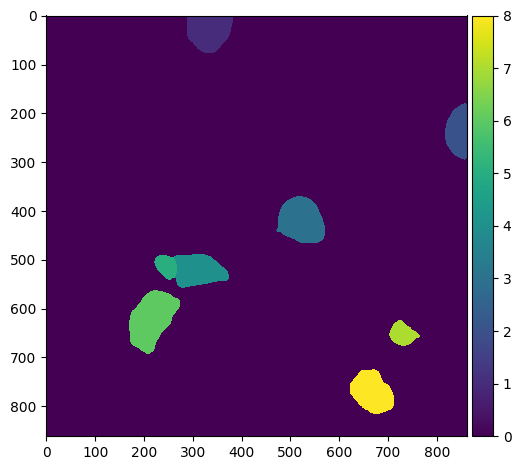

Cell:  3
Inclusion Area 62.0
Max Inclusion Area: 62.0
Cell Area: 5751.0
Ratio: 0.01078073378542862
Max Inclusion/Cell Area: 0.01078073378542862
Average Inclusion/Cell Area 0.01078073378542862


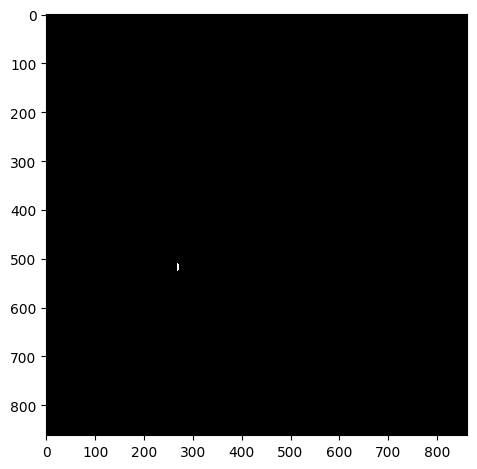

Cell:  5
Inclusion Area 367.0
Max Inclusion Area: 295.0
Cell Area: 8623.0
Ratio: 0.04256059376087209
Max Inclusion/Cell Area: 0.03421083149715876
Average Inclusion/Cell Area 0.021280296880436044


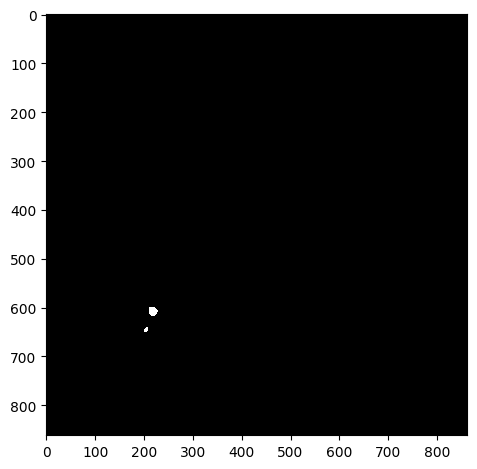

Cell:  6
Inclusion Area 357.0
Max Inclusion Area: 312.0
Cell Area: 2071.0
Ratio: 0.1723804925156929
Max Inclusion/Cell Area: 0.15065185900531144
Average Inclusion/Cell Area 0.057460164171897636


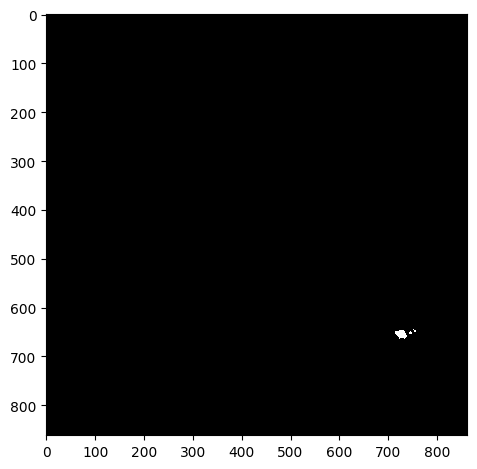

Cell:  7
Inclusion Area 184.0
Max Inclusion Area: 184.0
Cell Area: 5879.0
Ratio: 0.031297839768668144
Max Inclusion/Cell Area: 0.031297839768668144
Average Inclusion/Cell Area 0.031297839768668144


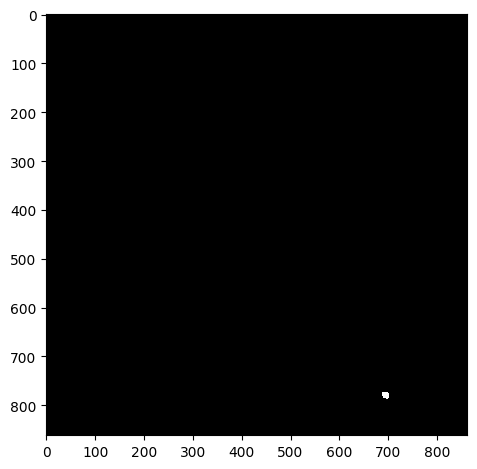

1K_PFF_no_HTRA1_Hoechst_20x_03.czi


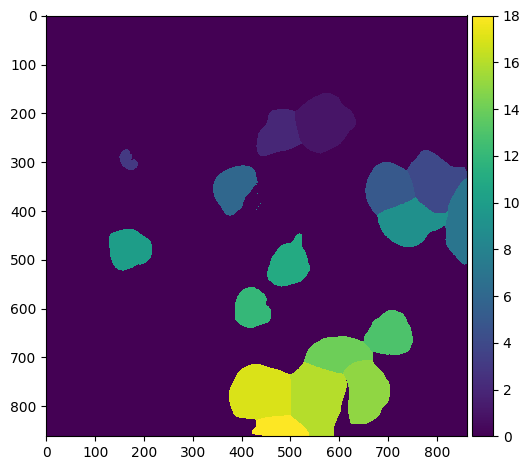

Cell:  21
Inclusion Area 1682.0
Max Inclusion Area: 1412.0
Cell Area: 5819.0
Ratio: 0.28905310190754424
Max Inclusion/Cell Area: 0.2426533768688778
Average Inclusion/Cell Area 0.07226327547688606


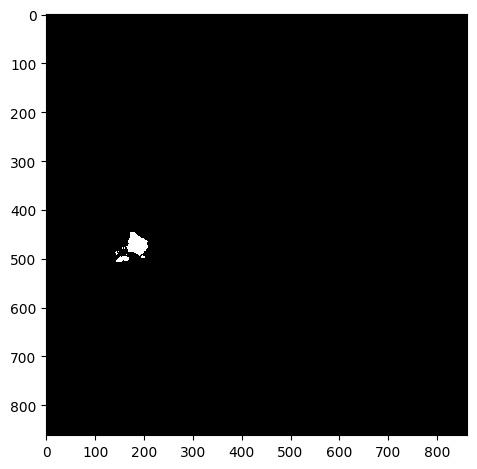

Cell:  23
Inclusion Area 442.0
Max Inclusion Area: 442.0
Cell Area: 4811.0
Ratio: 0.09187279151943463
Max Inclusion/Cell Area: 0.09187279151943463
Average Inclusion/Cell Area 0.09187279151943463


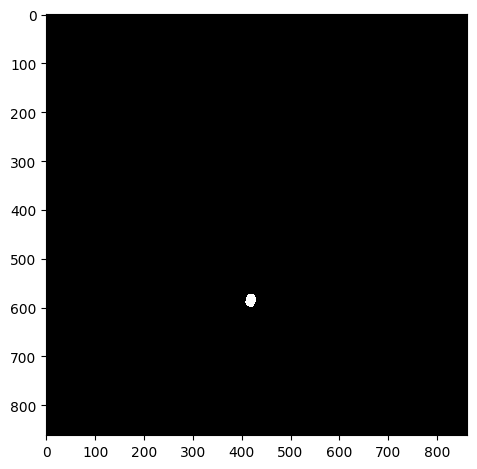

1K_PFF_no_HTRA1_Hoechst_20x_04.czi


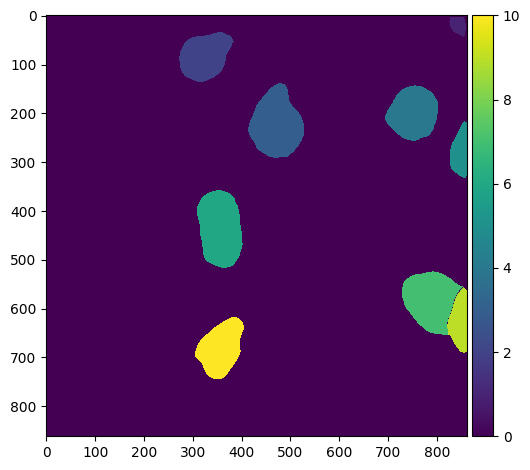

C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],


1K_PFF_no_HTRA1_Hoechst_20x_05.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


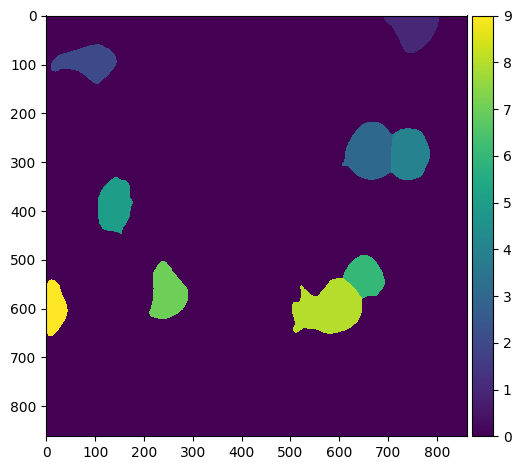

Cell:  4
Inclusion Area 82.0
Max Inclusion Area: 82.0
Cell Area: 6255.0
Ratio: 0.01310951239008793
Max Inclusion/Cell Area: 0.01310951239008793
Average Inclusion/Cell Area 0.01310951239008793


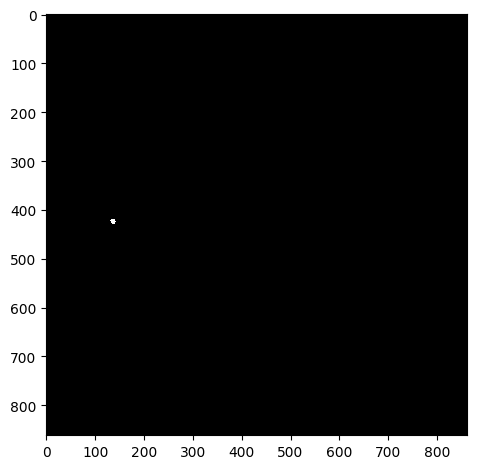

C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2309923543.py:136: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),
C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2309923543.py:137: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_HTRA_Area": np.array(overlap_areas)/np.array(htra_areas)


1K_PFF_no_HTRA1_Hoechst_20x_06.czi


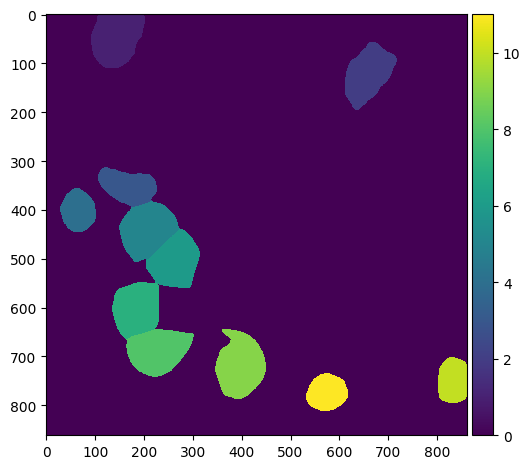

Cell:  1
Inclusion Area 805.0
Max Inclusion Area: 805.0
Cell Area: 9083.0
Ratio: 0.08862710558185621
Max Inclusion/Cell Area: 0.08862710558185621
Average Inclusion/Cell Area 0.08862710558185621


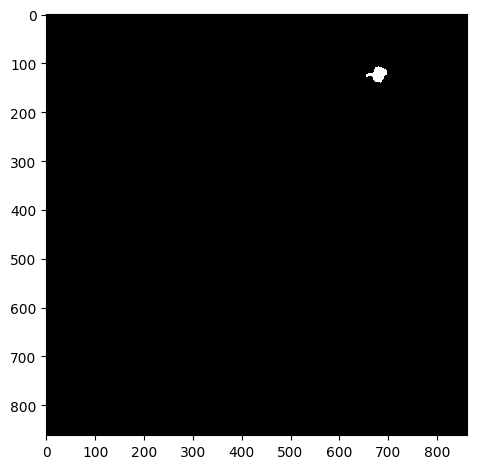

Cell:  2
Inclusion Area 1139.0
Max Inclusion Area: 799.0
Cell Area: 6698.0
Ratio: 0.1700507614213198
Max Inclusion/Cell Area: 0.11928934010152284
Average Inclusion/Cell Area 0.02834179357021997


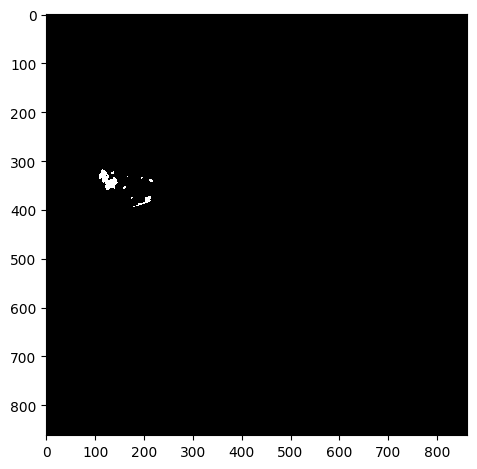

1K_PFF_no_HTRA1_Hoechst_20x_07.czi


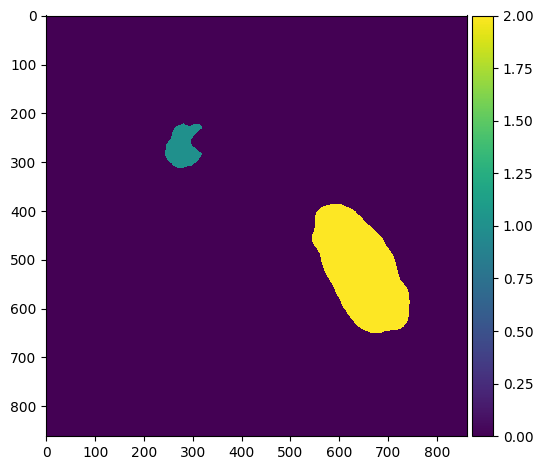

Cell:  0
Inclusion Area 40.0
Max Inclusion Area: 40.0
Cell Area: 4770.0
Ratio: 0.008385744234800839
Max Inclusion/Cell Area: 0.008385744234800839
Average Inclusion/Cell Area 0.008385744234800839


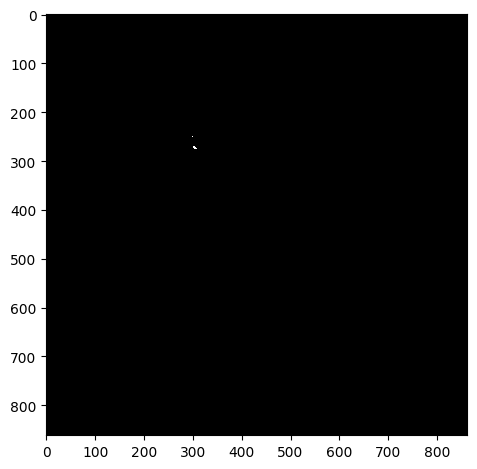

Cell:  1
Inclusion Area 1066.0
Max Inclusion Area: 1066.0
Cell Area: 33274.0
Ratio: 0.03203702590611288
Max Inclusion/Cell Area: 0.03203702590611288
Average Inclusion/Cell Area 0.03203702590611288


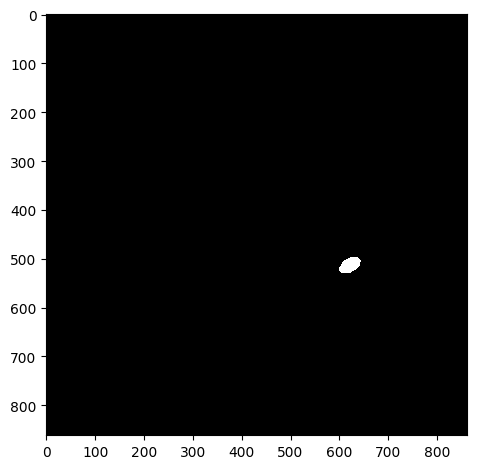

1K_PFF_no_HTRA1_Hoechst_20x_08.czi


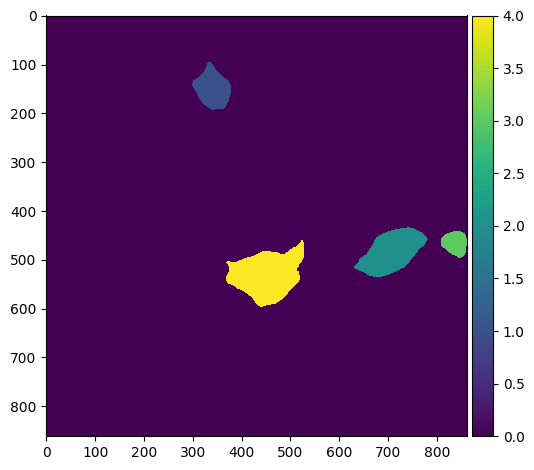

Cell:  3
Inclusion Area 1363.0
Max Inclusion Area: 678.0
Cell Area: 12825.0
Ratio: 0.10627680311890839
Max Inclusion/Cell Area: 0.05286549707602339
Average Inclusion/Cell Area 0.026569200779727097


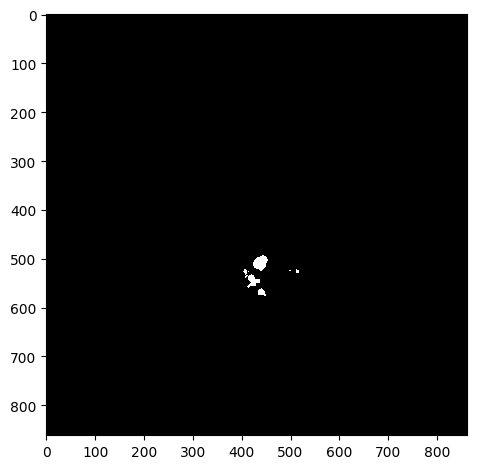

1K_PFF_no_HTRA1_Hoechst_20x_09.czi


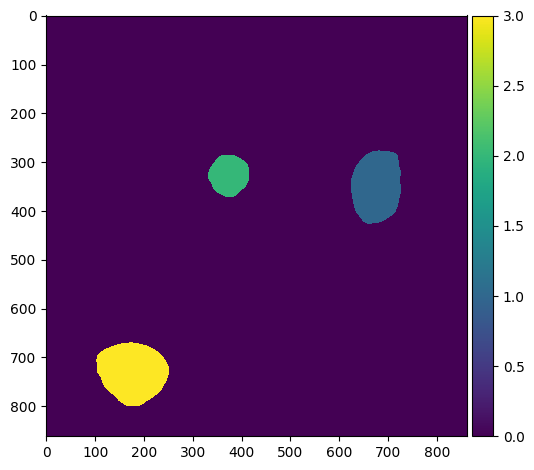

Cell:  1
Inclusion Area 373.0
Max Inclusion Area: 373.0
Cell Area: 5634.0
Ratio: 0.06620518281860135
Max Inclusion/Cell Area: 0.06620518281860135
Average Inclusion/Cell Area 0.06620518281860135


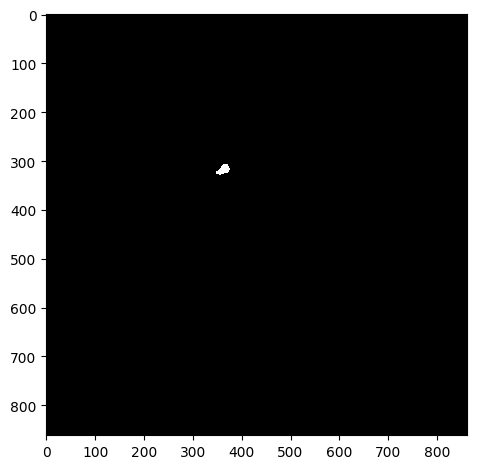

1K_PFF_no_HTRA1_Hoechst_20x_10.czi


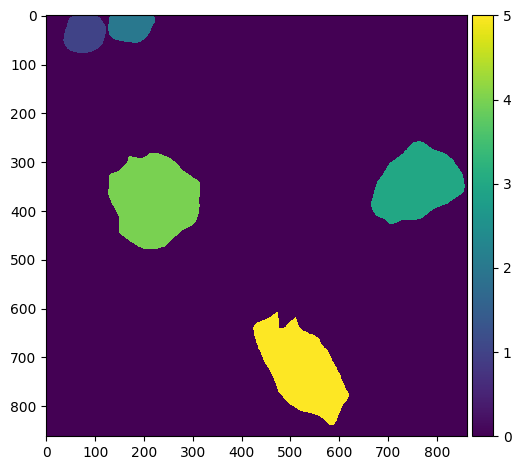

Cell:  3
Inclusion Area 4218.0
Max Inclusion Area: 850.0
Cell Area: 27495.0
Ratio: 0.15340971085651936
Max Inclusion/Cell Area: 0.030914711765775597
Average Inclusion/Cell Area 0.003933582329654343


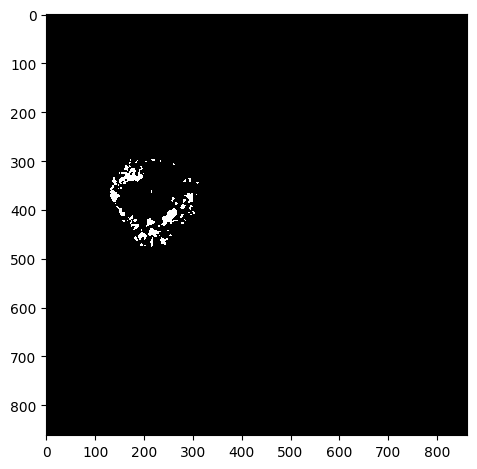

Cell:  4
Inclusion Area 787.0
Max Inclusion Area: 673.0
Cell Area: 24627.0
Ratio: 0.031956795387176676
Max Inclusion/Cell Area: 0.02732772972753482
Average Inclusion/Cell Area 0.015978397693588338


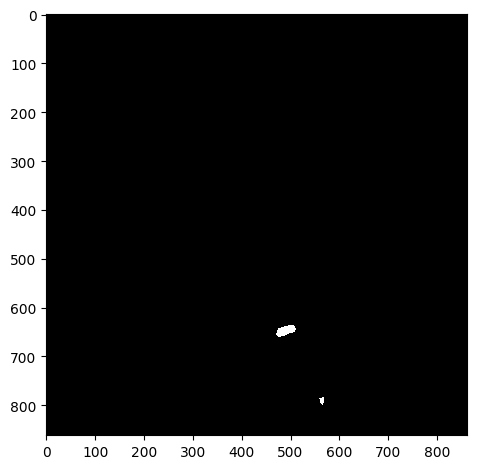

WT_PFF_HTRA1_Hoechst_20x_01.czi


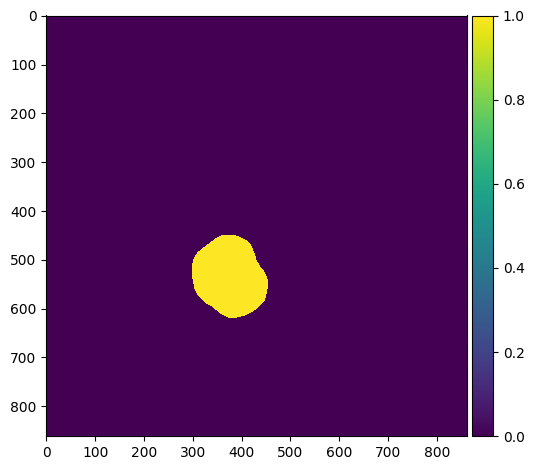

Cell:  0
Inclusion Area 1123.0
Max Inclusion Area: 333.0
Cell Area: 19751.0
Ratio: 0.05685788061363982
Max Inclusion/Cell Area: 0.016859905827553034
Average Inclusion/Cell Area 0.00437368312412614


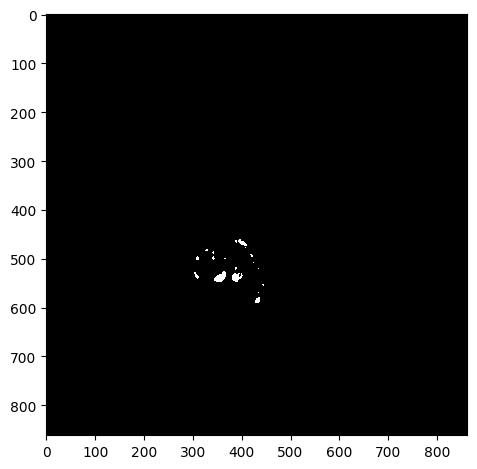

WT_PFF_HTRA1_Hoechst_20x_02.czi


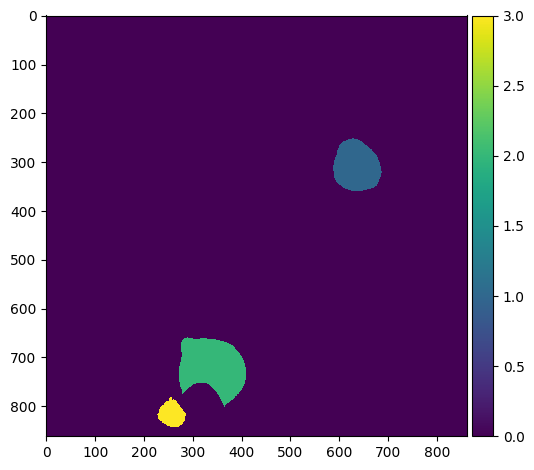

Cell:  1
Inclusion Area 217.0
Max Inclusion Area: 114.0
Cell Area: 13315.0
Ratio: 0.016297408937288774
Max Inclusion/Cell Area: 0.008561772437101014
Average Inclusion/Cell Area 0.005432469645762924


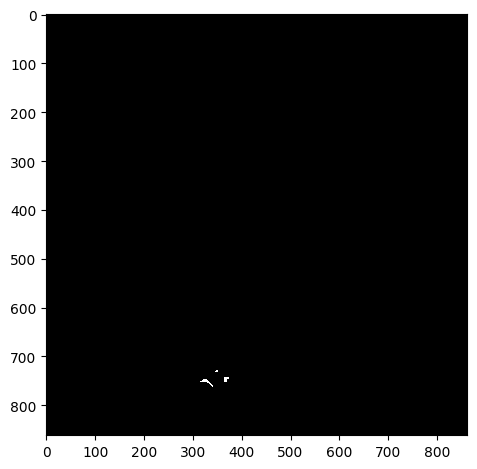

WT_PFF_HTRA1_Hoechst_20x_03.czi


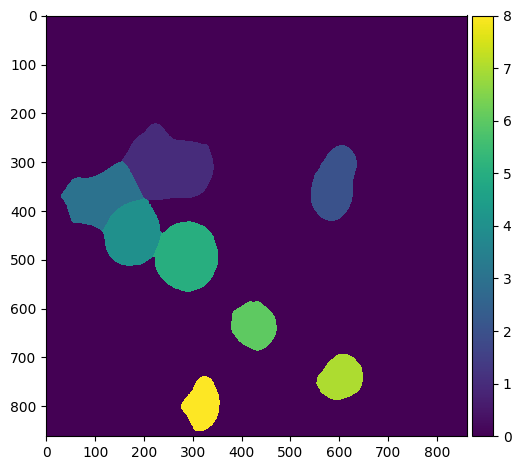

Cell:  5
Inclusion Area 804.0
Max Inclusion Area: 246.0
Cell Area: 7123.0
Ratio: 0.11287378913379194
Max Inclusion/Cell Area: 0.03453601010810052
Average Inclusion/Cell Area 0.011287378913379194


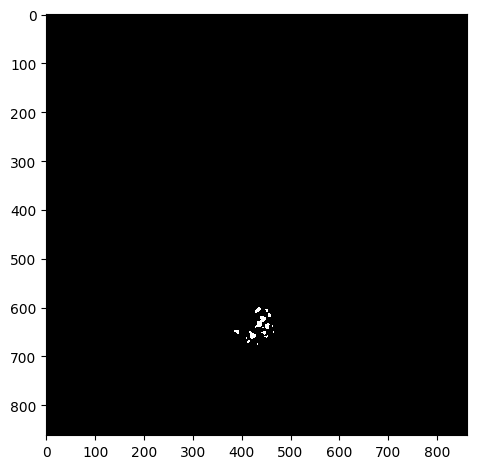

Cell:  6
Inclusion Area 564.0
Max Inclusion Area: 564.0
Cell Area: 6641.0
Ratio: 0.08492696882999548
Max Inclusion/Cell Area: 0.08492696882999548
Average Inclusion/Cell Area 0.08492696882999548


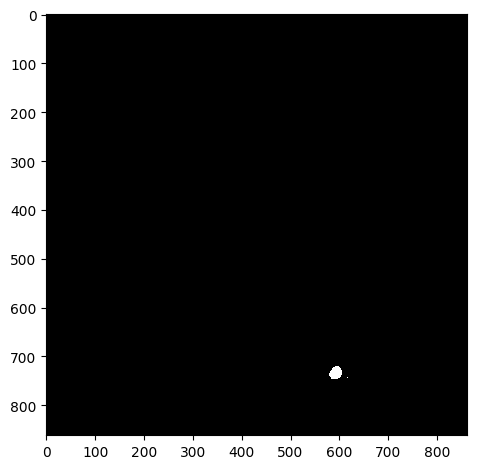

WT_PFF_HTRA1_Hoechst_20x_04.czi


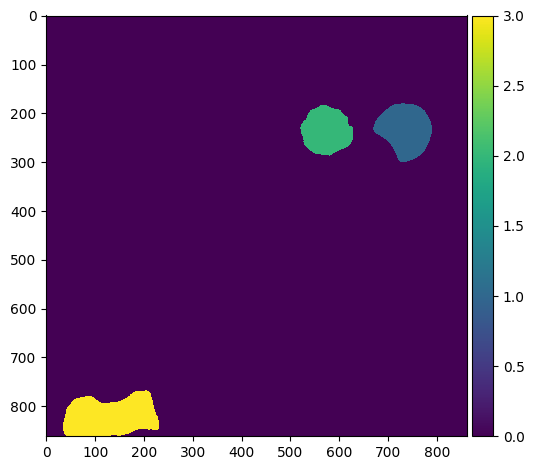

Cell:  1
Inclusion Area 534.0
Max Inclusion Area: 534.0
Cell Area: 8274.0
Ratio: 0.06453952139231327
Max Inclusion/Cell Area: 0.06453952139231327
Average Inclusion/Cell Area 0.06453952139231327


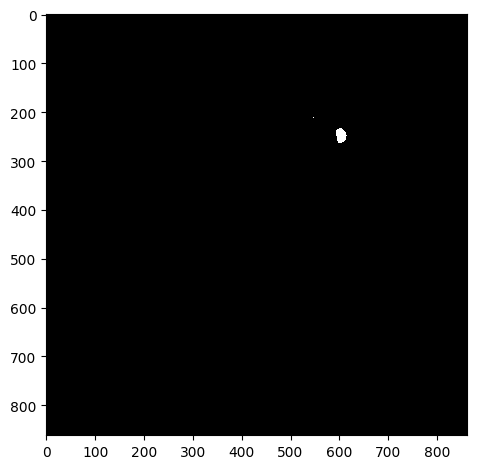

WT_PFF_HTRA1_Hoechst_20x_05.czi


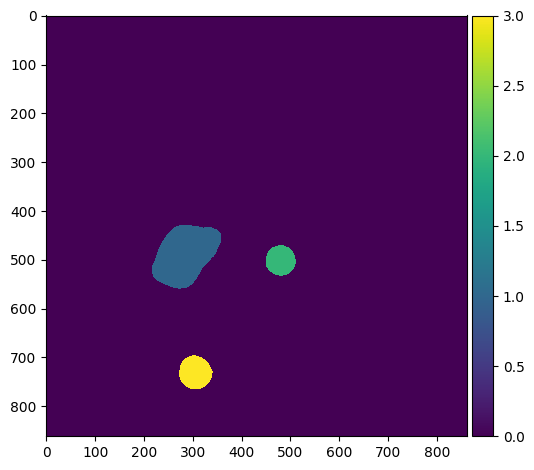

Cell:  0
Inclusion Area 2230.0
Max Inclusion Area: 1201.0
Cell Area: 12755.0
Ratio: 0.17483339866718933
Max Inclusion/Cell Area: 0.09415915327322619
Average Inclusion/Cell Area 0.024976199809598476


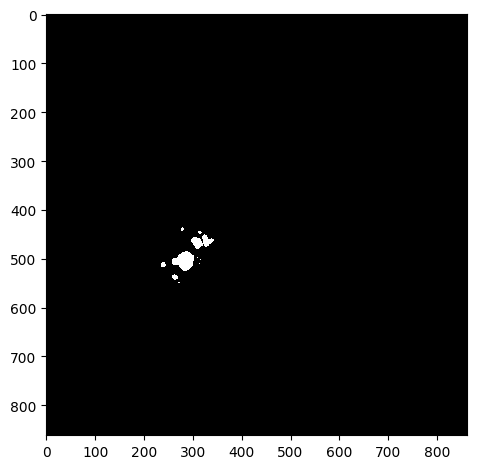

WT_PFF_HTRA1_Hoechst_20x_06.czi


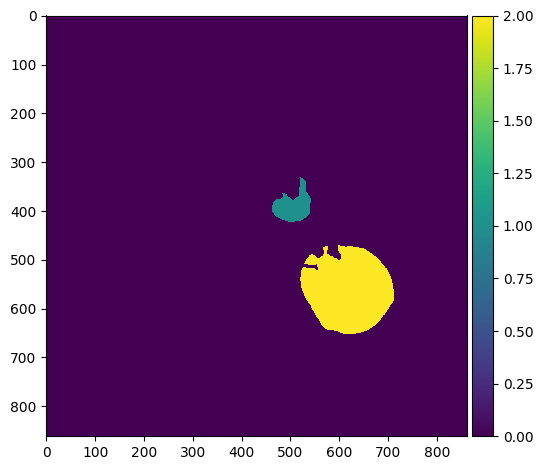

Cell:  1
Inclusion Area 503.0
Max Inclusion Area: 503.0
Cell Area: 25780.0
Ratio: 0.01951124903025601
Max Inclusion/Cell Area: 0.01951124903025601
Average Inclusion/Cell Area 0.01951124903025601


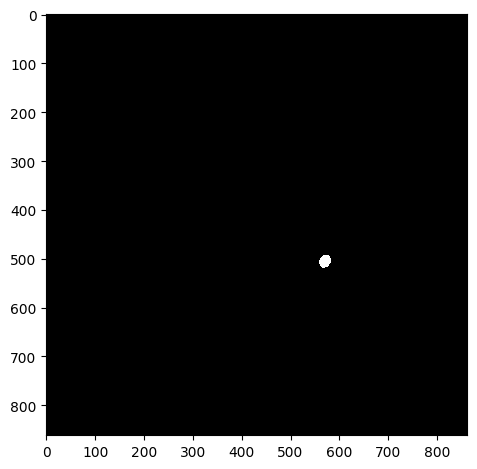

WT_PFF_HTRA1_Hoechst_20x_07.czi


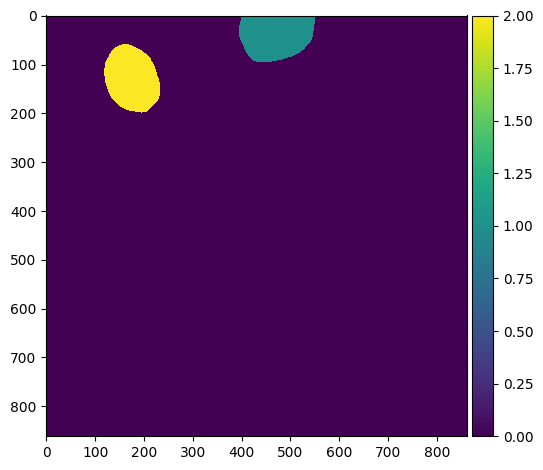

C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],


WT_PFF_HTRA1_Hoechst_20x_08.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


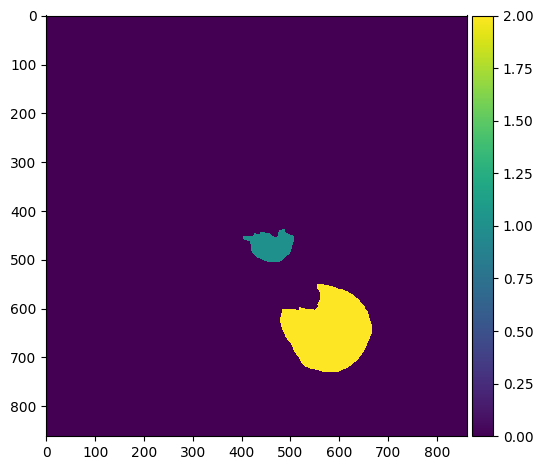

Cell:  1
Inclusion Area 3433.0
Max Inclusion Area: 1186.0
Cell Area: 22914.0
Ratio: 0.1498210700881557
Max Inclusion/Cell Area: 0.05175875010910361
Average Inclusion/Cell Area 0.016646785565350635


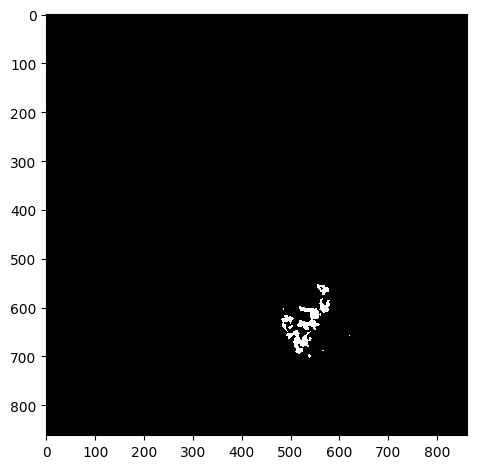

C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2309923543.py:136: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),


WT_PFF_HTRA1_Hoechst_20x_09.czi


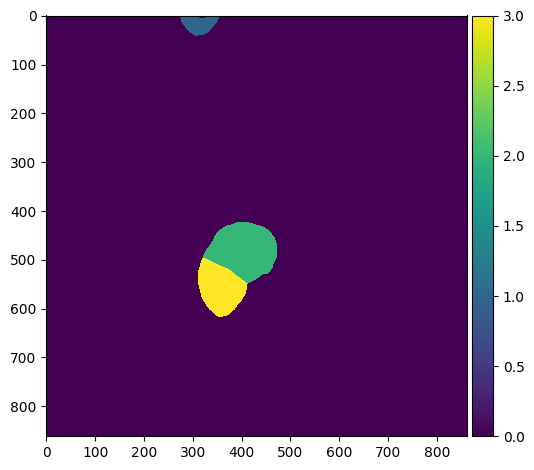

Cell:  2
Inclusion Area 228.0
Max Inclusion Area: 228.0
Cell Area: 8083.0
Ratio: 0.02820734875664976
Max Inclusion/Cell Area: 0.02820734875664976
Average Inclusion/Cell Area 0.02820734875664976


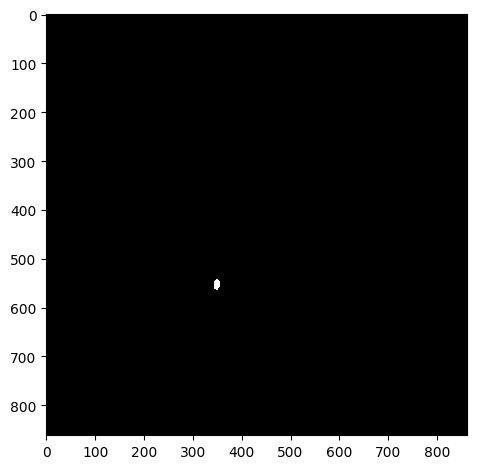

WT_PFF_HTRA1_Hoechst_20x_10.czi


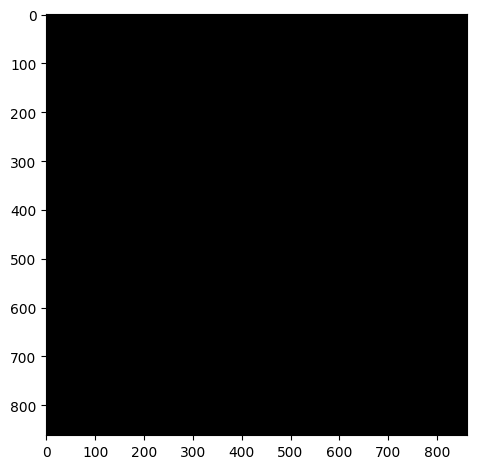

C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],
C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2113827453.py:37: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_HTRA_Area": [np.sum(overlap_areas) / np.sum(htra_areas)],


WT_PFF_no_HTRA1_Hoechst_20x_01.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


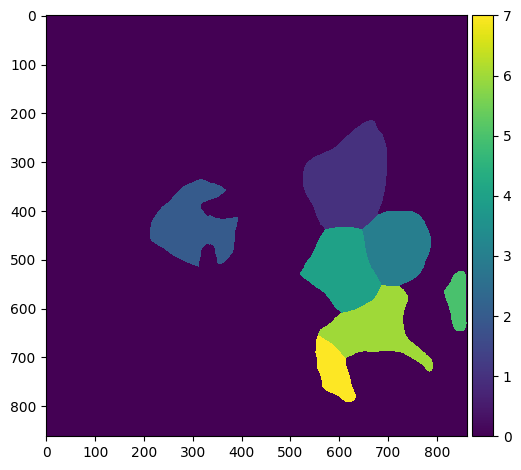

Cell:  1
Inclusion Area 92.0
Max Inclusion Area: 70.0
Cell Area: 19446.0
Ratio: 0.0047310500874215775
Max Inclusion/Cell Area: 0.003599712023038157
Average Inclusion/Cell Area 0.0023655250437107887


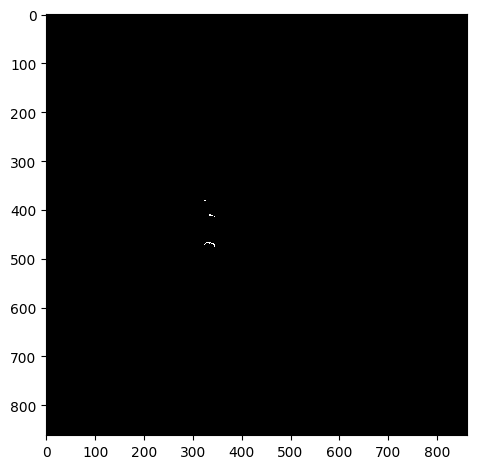

C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2309923543.py:136: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),


WT_PFF_no_HTRA1_Hoechst_20x_02.czi


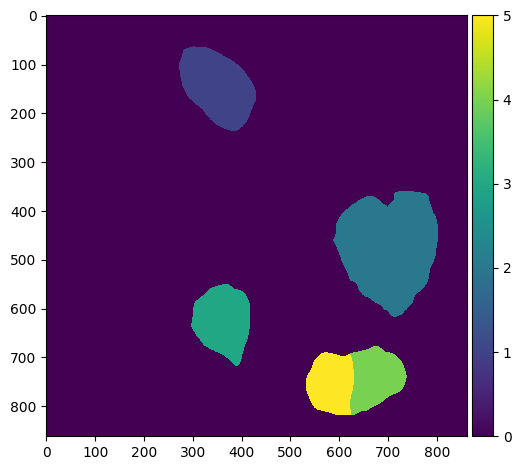

Cell:  2
Inclusion Area 575.0
Max Inclusion Area: 575.0
Cell Area: 14324.0
Ratio: 0.04014241831890533
Max Inclusion/Cell Area: 0.04014241831890533
Average Inclusion/Cell Area 0.04014241831890533


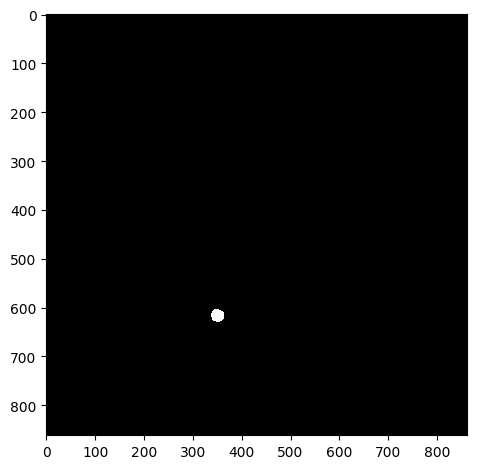

WT_PFF_no_HTRA1_Hoechst_20x_03.czi


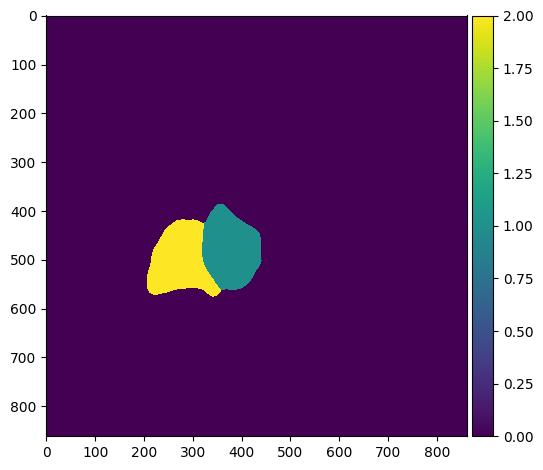

Cell:  1
Inclusion Area 430.0
Max Inclusion Area: 430.0
Cell Area: 15606.0
Ratio: 0.02755350506215558
Max Inclusion/Cell Area: 0.02755350506215558
Average Inclusion/Cell Area 0.02755350506215558


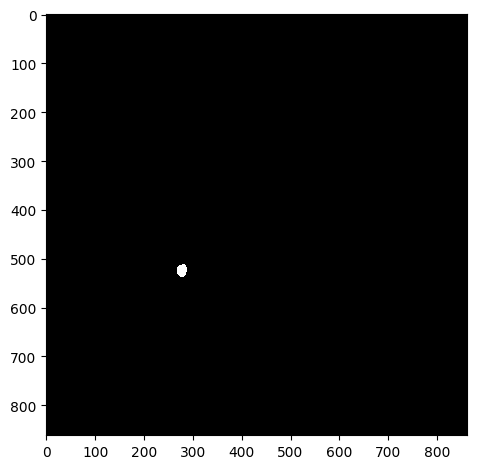

WT_PFF_no_HTRA1_Hoechst_20x_04.czi


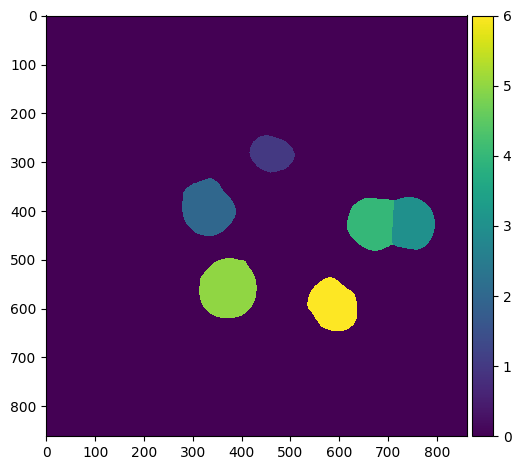

Cell:  5
Inclusion Area 515.0
Max Inclusion Area: 515.0
Cell Area: 8380.0
Ratio: 0.06145584725536993
Max Inclusion/Cell Area: 0.06145584725536993
Average Inclusion/Cell Area 0.06145584725536993


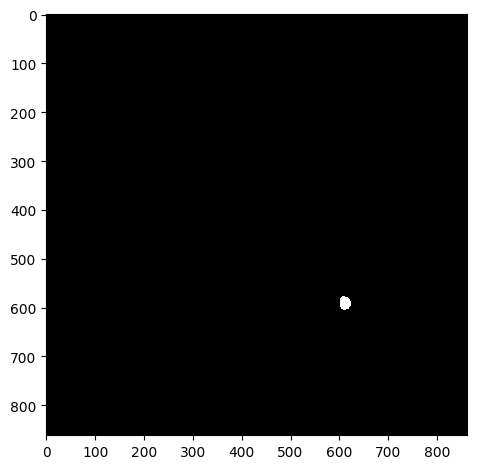

C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2309923543.py:137: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_HTRA_Area": np.array(overlap_areas)/np.array(htra_areas)


WT_PFF_no_HTRA1_Hoechst_20x_05.czi


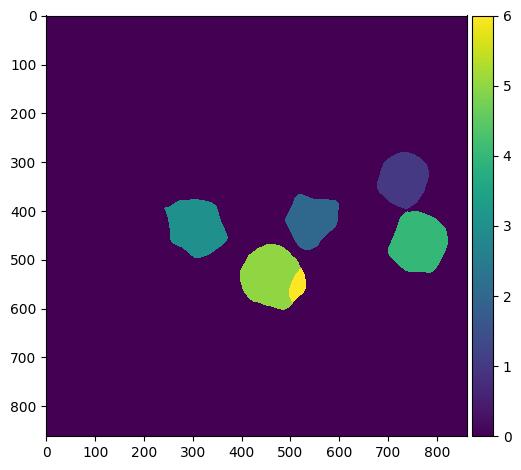

Cell:  4
Inclusion Area 251.0
Max Inclusion Area: 133.0
Cell Area: 11857.0
Ratio: 0.02116892974614152
Max Inclusion/Cell Area: 0.011217002614489331
Average Inclusion/Cell Area 0.007056309915380507


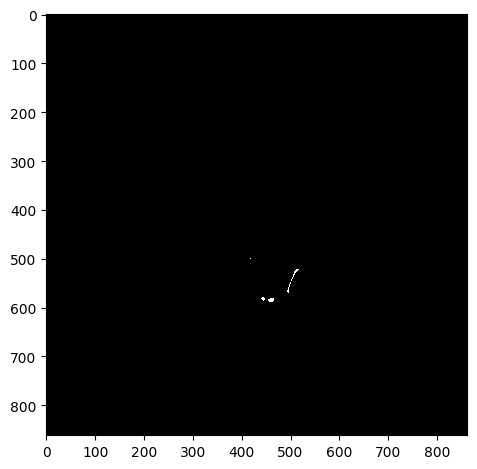

WT_PFF_no_HTRA1_Hoechst_20x_06.czi


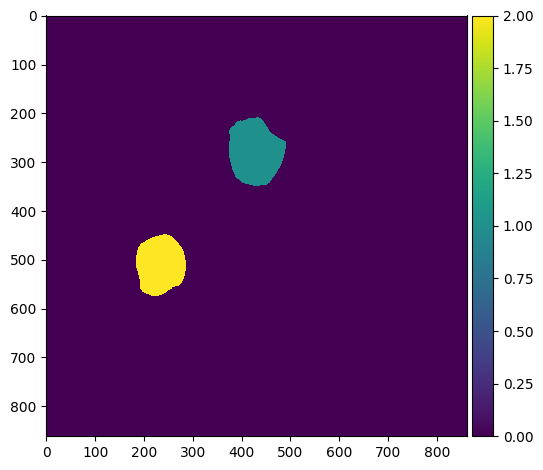

Cell:  0
Inclusion Area 2266.0
Max Inclusion Area: 1926.0
Cell Area: 12421.0
Ratio: 0.182432976410917
Max Inclusion/Cell Area: 0.1550599790677079
Average Inclusion/Cell Area 0.015202748034243084


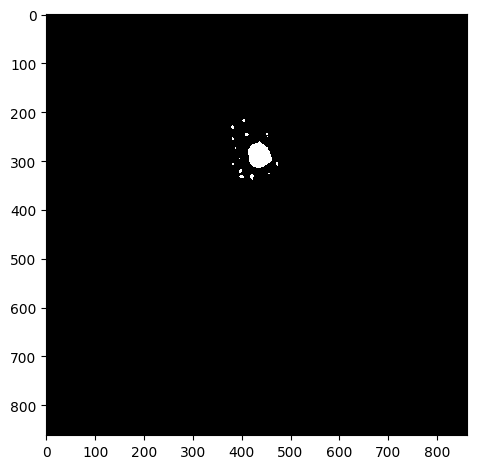

WT_PFF_no_HTRA1_Hoechst_20x_07.czi


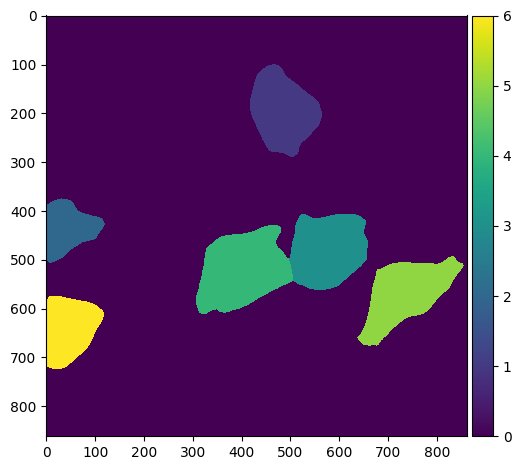

Cell:  3
Inclusion Area 1030.0
Max Inclusion Area: 618.0
Cell Area: 24729.0
Ratio: 0.04165150228476687
Max Inclusion/Cell Area: 0.024990901370860123
Average Inclusion/Cell Area 0.008330300456953375


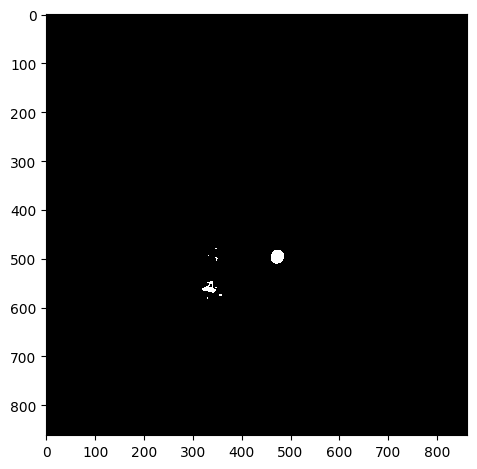

WT_PFF_no_HTRA1_Hoechst_20x_08.czi


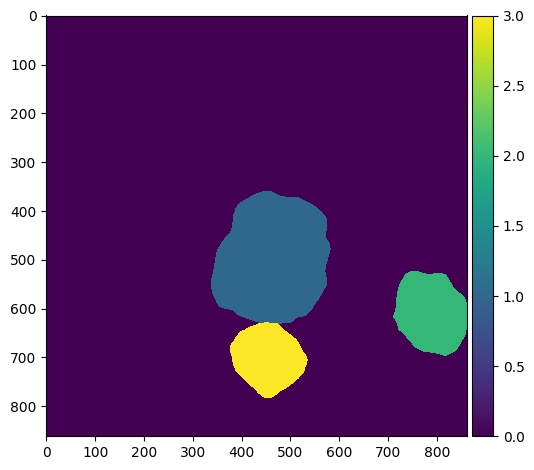

Cell:  0
Inclusion Area 1361.0
Max Inclusion Area: 1361.0
Cell Area: 51688.0
Ratio: 0.026331063302894288
Max Inclusion/Cell Area: 0.026331063302894288
Average Inclusion/Cell Area 0.026331063302894288


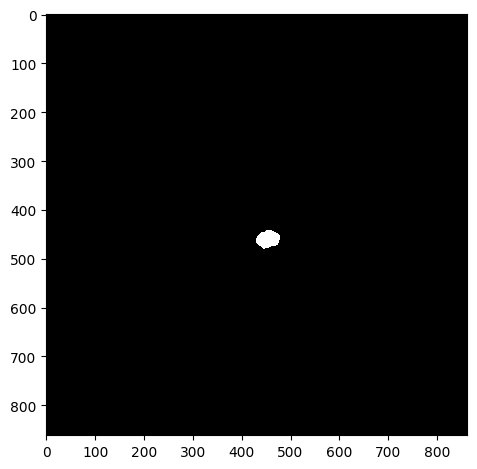

WT_PFF_no_HTRA1_Hoechst_20x_09.czi


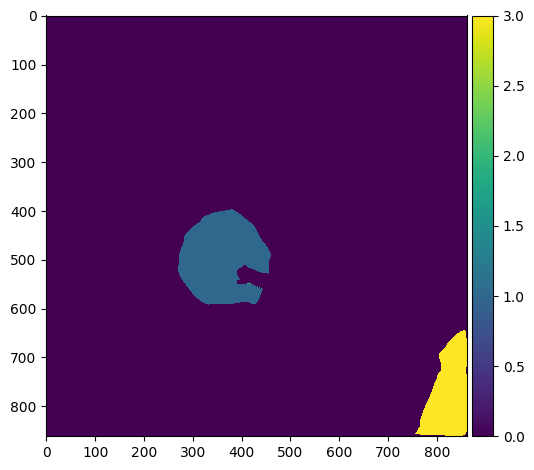

Cell:  0
Inclusion Area 35.0
Max Inclusion Area: 35.0
Cell Area: 26625.0
Ratio: 0.0013145539906103286
Max Inclusion/Cell Area: 0.0013145539906103286
Average Inclusion/Cell Area 0.0013145539906103286


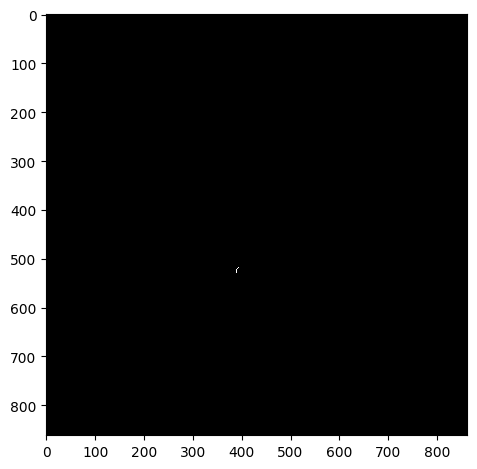

C:\Users\yh1024\AppData\Local\Temp\ipykernel_38888\2113827453.py:37: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_HTRA_Area": [np.sum(overlap_areas) / np.sum(htra_areas)],


WT_PFF_no_HTRA1_Hoechst_20x_10.czi


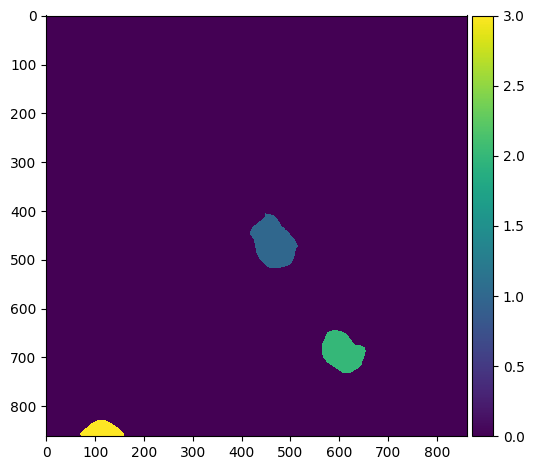

Cell:  0
Inclusion Area 661.0
Max Inclusion Area: 661.0
Cell Area: 7142.0
Ratio: 0.09255110613273593
Max Inclusion/Cell Area: 0.09255110613273593
Average Inclusion/Cell Area 0.09255110613273593


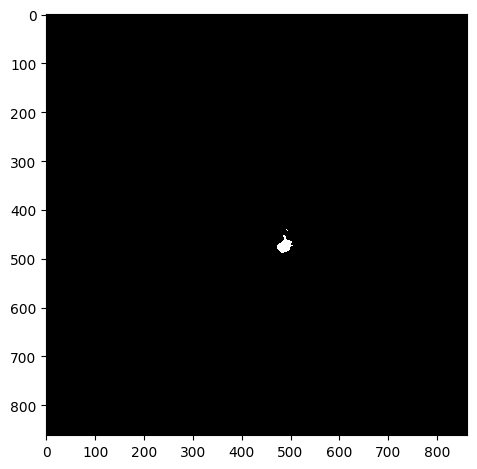

Cell:  1
Inclusion Area 481.0
Max Inclusion Area: 361.0
Cell Area: 5459.0
Ratio: 0.08811137570983697
Max Inclusion/Cell Area: 0.06612932771569885
Average Inclusion/Cell Area 0.022027843927459243


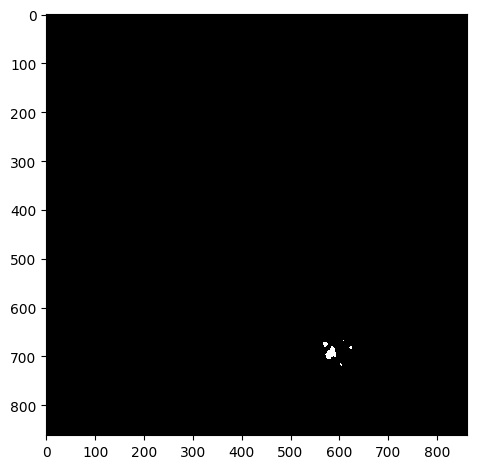

In [5]:
if __name__ == "__main__":
    
    # analyze_all_images('110724_PFF_HTRA1')
    # analyze_all_images('103124_PFF_HTRA1/new new settings')
    analyze_all_images('112124_PFF_HTRA1')
